## Problem Statement
We are going to classify the delays in domestic flights using the dataset from the month of February that is made publicly available by the Bureau of Transportation Statistics, Govt of USA.

We are going to use *logistic regrssion* as the primary classifier but as we go along we'll also use *SVM* and *Neural Networks* based on the accuracy of the predictor!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("Feb_2020_ontime.csv")

In [3]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,6,MQ,20398,MQ,N269NN,3825,13930,1393007,ORD,...,TUL,1646.0,0.0,1600-1659,1820.0,0.0,0.0,0.0,585.0,NaN
1,1,6,MQ,20398,MQ,N908AE,3829,12478,1247805,JFK,...,BNA,1336.0,0.0,1300-1359,1458.0,0.0,0.0,0.0,765.0,NaN
2,1,6,MQ,20398,MQ,N663AR,3831,11953,1195302,GNV,...,MIA,844.0,0.0,0800-0859,1020.0,1.0,0.0,0.0,294.0,NaN
3,1,6,MQ,20398,MQ,N618AE,3833,11298,1129806,DFW,...,SJT,852.0,0.0,0800-0859,955.0,0.0,0.0,0.0,229.0,NaN
4,1,6,MQ,20398,MQ,N618AE,3833,14842,1484202,SJT,...,DFW,1024.0,0.0,1000-1059,1132.0,0.0,0.0,0.0,229.0,NaN


In [4]:
#Let's go ahead and delete the last column in dataset
df.drop("Unnamed: 21", axis = 1, inplace = True)
#Let's check for the columns name and understand what we can work with 
df.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE'],
      dtype='object')

In [5]:
# let's explore a bit more and understand what some of these columns represent 
df['OP_UNIQUE_CARRIER'].unique()

array(['MQ', 'B6', 'OH', 'AA', 'NK', 'YX', 'F9', 'DL', 'YV', 'EV', 'HA',
       '9E', 'G4', 'UA', 'AS', 'WN', 'OO'], dtype=object)

In [6]:
df['OP_CARRIER_AIRLINE_ID'].unique()

array([20398, 20409, 20397, 19805, 20416, 20452, 20436, 19790, 20378,
       20366, 19690, 20363, 20368, 19977, 19930, 19393, 20304])

In [7]:
df['OP_CARRIER'].unique()

array(['MQ', 'B6', 'OH', 'AA', 'NK', 'YX', 'F9', 'DL', 'YV', 'EV', 'HA',
       '9E', 'G4', 'UA', 'AS', 'WN', 'OO'], dtype=object)

In our case, **OP_UNIQUE_CARRIER, OP_CARRIER and OP_CARRIER_AIRLINE_ID** all kind of means the same thing. Those are codes assinged by the DOT to identify individual carriers. 

For our analysis let's use just **OP_CARRIER** and drop the other two columns.

Also, let's remove the **TAIL_NUM AND OP_CARRIER_FL_NUM** from our dataset. 

In [8]:
df.drop(['OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','DIVERTED'], axis = 1, inplace = True)

In [9]:
#Checking for nulll values before moving forward 
df.isna().sum()

DAY_OF_MONTH                0
DAY_OF_WEEK                 0
OP_CARRIER                  0
ORIGIN_AIRPORT_ID           0
ORIGIN_AIRPORT_SEQ_ID       0
ORIGIN                      0
DEST_AIRPORT_ID             0
DEST_AIRPORT_SEQ_ID         0
DEST                        0
DEP_TIME                 4938
DEP_DEL15                4951
DEP_TIME_BLK                0
ARR_TIME                 5287
ARR_DEL15                6192
CANCELLED                   0
DISTANCE                    0
dtype: int64

In [10]:
# Let's go ahead and drop all the null values and store it in a new dataframe for ease of computation
df1 = df.fillna(method = 'ffill')

Now let's use the `describe` function to see how our data looks.

In [11]:
df1.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEP_TIME,DEP_DEL15,ARR_TIME,ARR_DEL15,CANCELLED,DISTANCE
count,574268.000000,574268.000000,574268.000000,5.742680e+05,574268.000000,5.742680e+05,574268.000000,574268.000000,574268.000000,574268.000000,574268.000000,574268.000000
mean,15.179477,3.989280,12658.021716,1.265806e+06,12658.143861,1.265818e+06,1332.908461,0.145885,1478.573748,0.151156,0.008942,795.735522
std,8.295999,1.988345,1524.563452,1.524561e+05,1524.594853,1.524592e+05,498.981746,0.352991,528.104272,0.358201,0.094138,582.960817
min,1.000000,1.000000,10135.000000,1.013506e+06,10135.000000,1.013506e+06,1.000000,0.000000,1.000000,0.000000,0.000000,31.000000
25%,8.000000,2.000000,11292.000000,1.129202e+06,11292.000000,1.129202e+06,918.000000,0.000000,1058.000000,0.000000,0.000000,369.000000
50%,15.000000,4.000000,12889.000000,1.288903e+06,12889.000000,1.288903e+06,1328.000000,0.000000,1513.000000,0.000000,0.000000,641.000000
75%,22.000000,6.000000,14027.000000,1.402702e+06,14027.000000,1.402702e+06,1741.000000,0.000000,1920.000000,0.000000,0.000000,1036.000000
max,29.000000,7.000000,16869.000000,1.686901e+06,16869.000000,1.686901e+06,2400.000000,1.000000,2400.000000,1.000000,1.000000,5095.000000


In [12]:
#Starting by binning the distance column into four different subgroups 
bin_labels = ['1','2','3','4']
bins_level = [0,400,800,1200,10000] #Including a huge value to include all values above 1200
df1['Binned_Distance_Labels'] = pd.cut(df1['DISTANCE'], bins = bins_level, labels = bin_labels )

So we have binned the distance column. I have used bin labels to be 1,2,3 and 4 just for the ease of use and it can be easily fit into the model without encoding

For reference, distances from 

(0 - 400] miles = 1

(400 - 800] miles = 2

(800 - 1200] miles = 3

(1200 - 10000] miles = 4

In [13]:
#Now we can drop the distance column
df1.drop(['DISTANCE'], axis = 1, inplace = True)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574268 entries, 0 to 574267
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   DAY_OF_MONTH            574268 non-null  int64   
 1   DAY_OF_WEEK             574268 non-null  int64   
 2   OP_CARRIER              574268 non-null  object  
 3   ORIGIN_AIRPORT_ID       574268 non-null  int64   
 4   ORIGIN_AIRPORT_SEQ_ID   574268 non-null  int64   
 5   ORIGIN                  574268 non-null  object  
 6   DEST_AIRPORT_ID         574268 non-null  int64   
 7   DEST_AIRPORT_SEQ_ID     574268 non-null  int64   
 8   DEST                    574268 non-null  object  
 9   DEP_TIME                574268 non-null  float64 
 10  DEP_DEL15               574268 non-null  float64 
 11  DEP_TIME_BLK            574268 non-null  object  
 12  ARR_TIME                574268 non-null  float64 
 13  ARR_DEL15               574268 non-null  float64 
 14  CANC

In [15]:
df1.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,Binned_Distance_Labels
0,1,6,MQ,13930,1393007,ORD,15370,1537002,TUL,1646.0,0.0,1600-1659,1820.0,0.0,0.0,2
1,1,6,MQ,12478,1247805,JFK,10693,1069302,BNA,1336.0,0.0,1300-1359,1458.0,0.0,0.0,2
2,1,6,MQ,11953,1195302,GNV,13303,1330303,MIA,844.0,0.0,0800-0859,1020.0,1.0,0.0,1
3,1,6,MQ,11298,1129806,DFW,14842,1484202,SJT,852.0,0.0,0800-0859,955.0,0.0,0.0,1
4,1,6,MQ,14842,1484202,SJT,11298,1129806,DFW,1024.0,0.0,1000-1059,1132.0,0.0,0.0,1


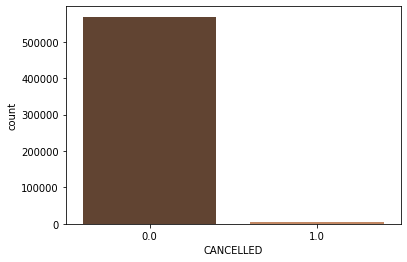

In [16]:
#Let's check how our target variable is distributed
sns.countplot(x = df1['CANCELLED'],palette= 'copper')

From the above plot we can see that our data is highly imblanced and we have to use oversampling and undersampling methodologies before we can train the model. 
But before that's let's do some EDA and understand how our regressors affect the target variable.

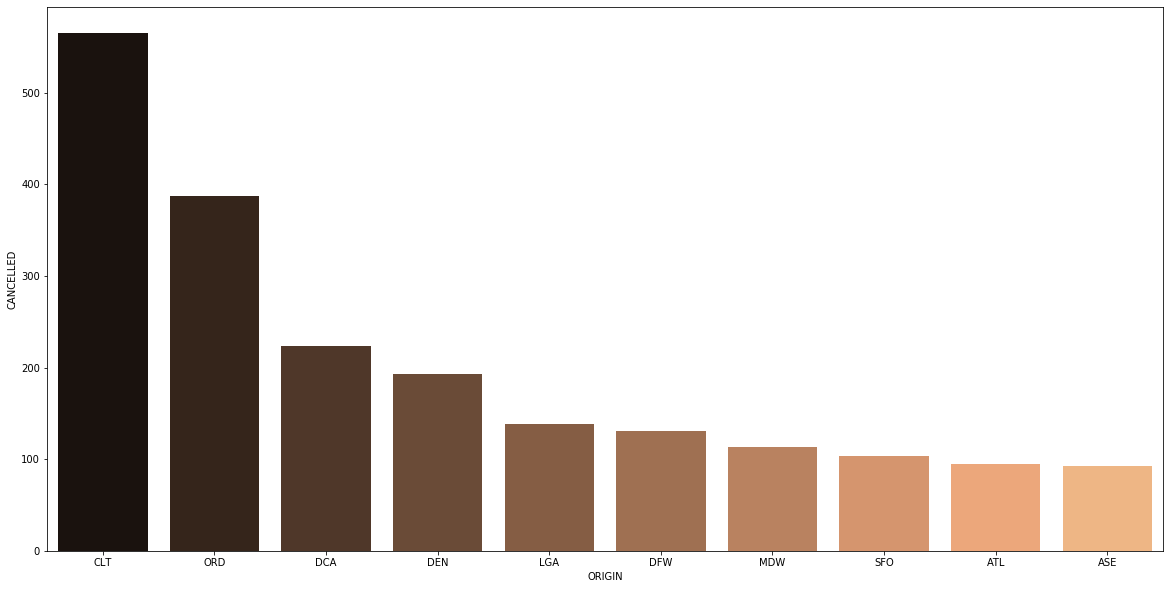

In [17]:
fig, ax = plt.subplots(figsize = (20,10))
df2 = df1[['ORIGIN','CANCELLED']].loc[df1['CANCELLED'] == 1].groupby('ORIGIN').count().sort_values(by = 'CANCELLED', ascending = False).reset_index() # Got the values of origins with the overall number of flight cancellations
sns.barplot(x = 'ORIGIN', y = 'CANCELLED', data = df2.head(10), ax = ax, palette = 'copper')

From the graph above, we can see that a lot of flights from Charlotte have been cancelled in the month of February. This could be due to the hard weather conditions in NC.

We can also understand from the plot that the origin does play a role in deciding if the flight is going to be cancelled or not. 

Text(0, 0.5, 'Total Number of flights cancelled')

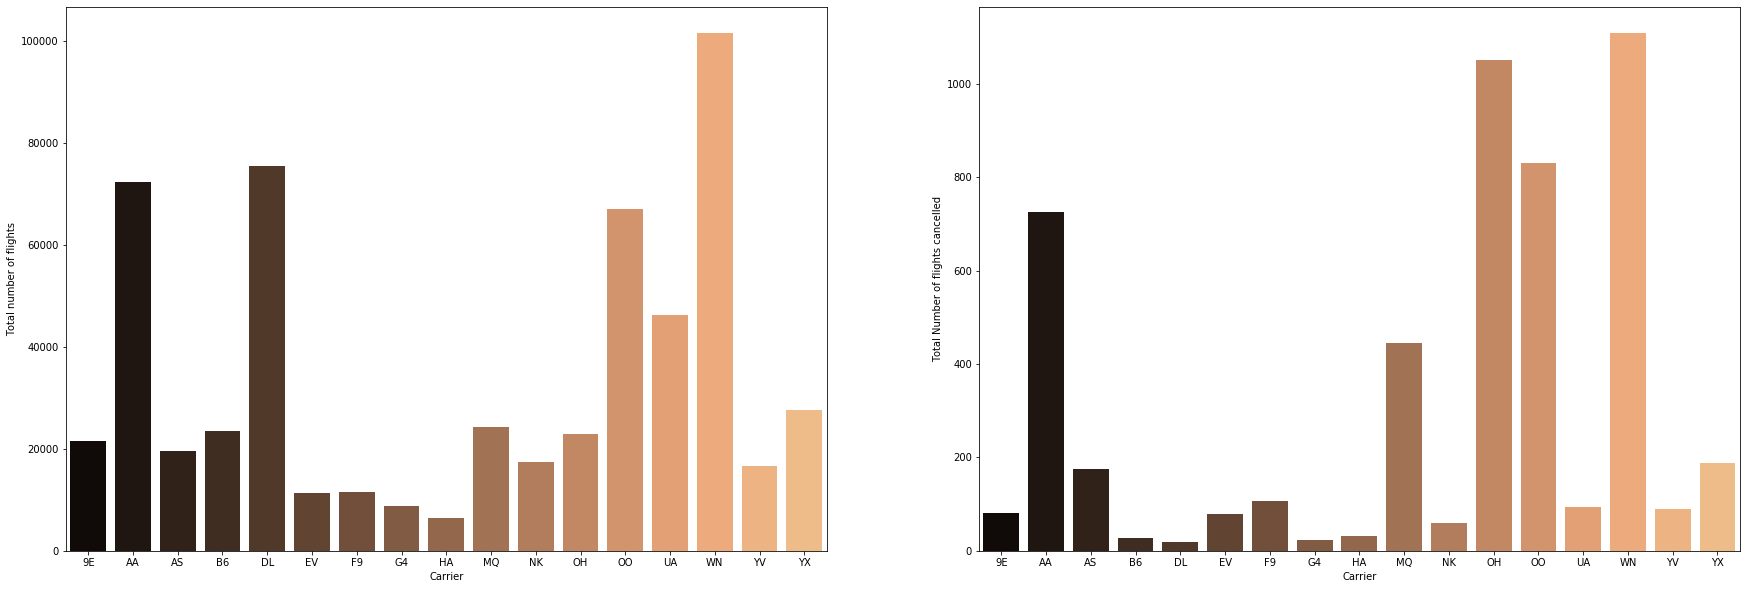

In [18]:
#moving on, let's see the relationship between Carriers and cancellations. 
df3 = df1[['OP_CARRIER','CANCELLED']].loc[df['CANCELLED']==1].groupby('OP_CARRIER').count().reset_index()
df4 = df1[['OP_CARRIER','CANCELLED']].groupby('OP_CARRIER').count().reset_index()
fig, ax = plt.subplots(1,2,figsize = (30,10))
a = sns.barplot(x = 'OP_CARRIER', y = 'CANCELLED', data = df4, palette = "copper",ax = ax[0])
a.set_xlabel("Carrier")
a.set_ylabel("Total number of flights")
b = sns.barplot(x = 'OP_CARRIER', y = 'CANCELLED', data = df3, palette = 'copper',ax = ax[1])
b.set_xlabel("Carrier")
b.set_ylabel("Total Number of flights cancelled")

We can see that Southwest(WN) is associated with large number of flights and also large number of flight cancellations. 

Delta on the other hand operates quite a lot of flights but the number of flights cancelled is actually pretty low. 

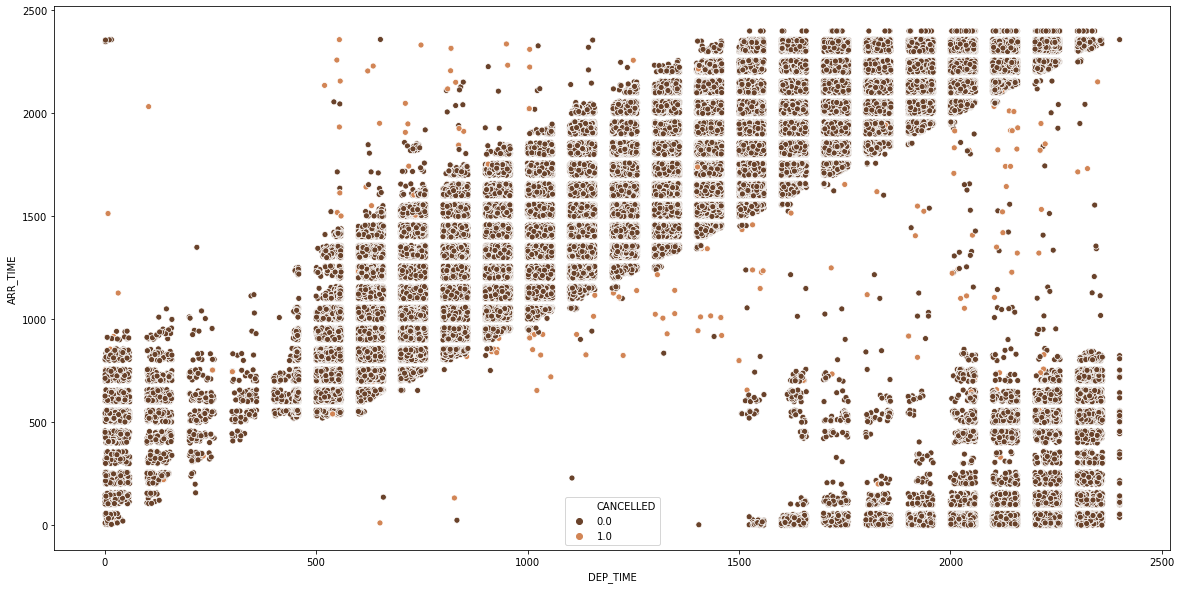

In [19]:
#Let's check if there is any pattern when comparing arrival and departure timings
plt.subplots(figsize = (20,10))
sns.scatterplot(x = 'DEP_TIME', y = 'ARR_TIME', hue = 'CANCELLED', data = df1,  palette = 'copper')

In [22]:
#Let's go ahead and use k fold and random forest model to train and fit our dataset 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574268 entries, 0 to 574267
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   DAY_OF_MONTH            574268 non-null  int64   
 1   DAY_OF_WEEK             574268 non-null  int64   
 2   OP_CARRIER              574268 non-null  object  
 3   ORIGIN_AIRPORT_ID       574268 non-null  int64   
 4   ORIGIN_AIRPORT_SEQ_ID   574268 non-null  int64   
 5   ORIGIN                  574268 non-null  object  
 6   DEST_AIRPORT_ID         574268 non-null  int64   
 7   DEST_AIRPORT_SEQ_ID     574268 non-null  int64   
 8   DEST                    574268 non-null  object  
 9   DEP_TIME                574268 non-null  float64 
 10  DEP_DEL15               574268 non-null  float64 
 11  DEP_TIME_BLK            574268 non-null  object  
 12  ARR_TIME                574268 non-null  float64 
 13  ARR_DEL15               574268 non-null  float64 
 14  CANC

In [24]:
X = df1[['OP_CARRIER','ORIGIN','Binned_Distance_Labels','DAY_OF_MONTH']]
y = df1['CANCELLED']

In [ ]:
X['Binned_Distance_Labels'] = X['Binned_Distance_Labels'].astype()